<a href="https://colab.research.google.com/github/MouadEttali/ComputerVision_DeepLearning/blob/main/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  intel-image-classification.zip
replace seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


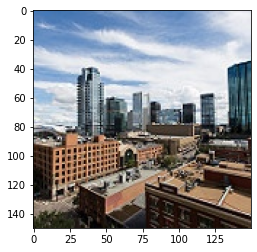

In [2]:
import matplotlib.pyplot as plt
import cv2

building_path = 'seg_train/seg_train/buildings/10006.jpg'
img_bgr = cv2.imread(building_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

In [3]:
img_rgb.shape

(150, 150, 3)

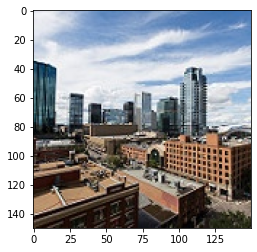

In [4]:
from tensorflow.image import random_flip_left_right

flipped_img = random_flip_left_right(img_rgb)

plt.imshow(flipped_img)

In [5]:
type(flipped_img)

tensorflow.python.framework.ops.EagerTensor

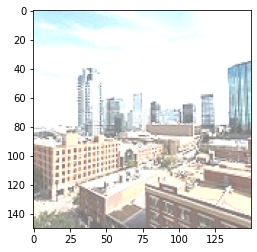

In [6]:
from tensorflow.image import random_brightness

brightness_changed_img = random_brightness(img_rgb, max_delta=0.5)

plt.imshow(brightness_changed_img)

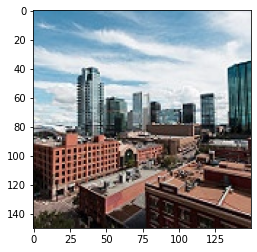

In [7]:
from tensorflow.image import random_hue

hue_changed_img = random_hue(img_rgb, max_delta=0.1)

plt.imshow(hue_changed_img)

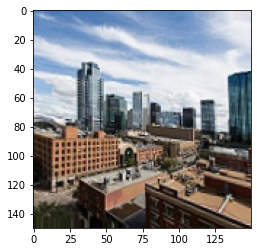

In [8]:
from tensorflow.keras.preprocessing.image import random_shear

sheared_img = random_shear(img_rgb, intensity=7, row_axis=0, col_axis=1, channel_axis=2)

plt.imshow(sheared_img)

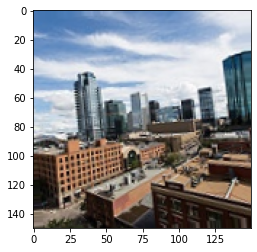

In [9]:
from tensorflow.keras.preprocessing.image import random_rotation

rotated_img = random_rotation(img_rgb, rg=10, row_axis=0, col_axis=1, channel_axis=2)

plt.imshow(rotated_img)

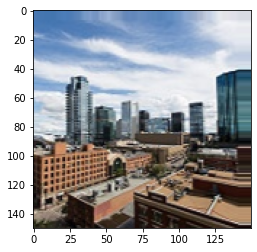

In [10]:
from tensorflow.keras.preprocessing.image import random_shift

shifted_img = random_shift(img_rgb, wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2)

plt.imshow(shifted_img)

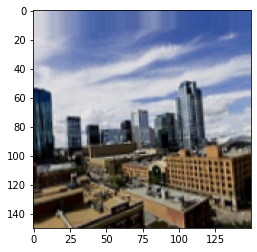

In [11]:
from tensorflow import clip_by_value

def augment(x):
  x = random_flip_left_right(x)
  x = random_brightness(x, max_delta=0.1)
  x = random_hue(x, max_delta=0.05).numpy()
  x = random_shear(x, intensity=1, row_axis=0, col_axis=1, channel_axis=2)
  x = random_rotation(x, rg=5, row_axis=0, col_axis=1, channel_axis=2)
  x = random_shift(x, wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2)
  x = clip_by_value(x, 0, 255)
  return x

augmented_img = augment(img_rgb)

plt.imshow(augmented_img)

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet

def preprocess_input(x):
  x = augment(x)
  x = preprocess_mobilenet(x)

  return x

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'seg_train/seg_train/'
VAL_DIR = 'seg_test/seg_test/'

train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_data_gen.flow_from_directory(TRAIN_DIR,
                                                     target_size=(150, 150),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_mobilenet)
val_generator = val_data_gen.flow_from_directory(VAL_DIR,
                                                target_size=(150,150),
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False
                                                )

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2

mobilenet = MobileNetV2(input_shape=((150, 150, 3)), include_top=False)

model = Sequential([layers.Input((150, 150, 3)),
                    mobilenet,
                    layers.GlobalAveragePooling2D(),
                    layers.Dropout(0.1),
                    layers.Dense(6, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


In [15]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=7)

Epoch 1/7
177/439 [===========>..................] - ETA: 3:13 - loss: 1.8216 - accuracy: 0.3609

KeyboardInterrupt: ignored